In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import time
import pickle
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
dvc = torch.device('cuda')

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)  

In [ ]:
#Load cifar dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 5s 0us/step


In [ ]:
# Reshape and normalize data via maximum pixel values
x_train_vector = x_train.reshape((x_train.shape[0],-1)).copy()
x_test_vector = x_test.reshape((x_test.shape[0],-1)).copy()
x_train_vector = x_train_vector/255.0
x_test_vector = x_test_vector / 255.0

In [ ]:
# Use 10% of training data as validation set
x_train_vector, x_val_vector, y_train, y_val = train_test_split(x_train_vector, y_train,
                                                             stratify=y_train, test_size=0.1, random_state=110)



In [ ]:
#Create unnormalized x vector
x_train_vector_unnorm = x_train_vector * 255.0
x_val_vector_unnorm = x_val_vector * 255.0
x_test_vector_unnorm = x_test_vector * 255.0

In [ ]:
print(f'Training data shape: {x_train_vector.shape}')
print(f'Validation data shape: {x_val_vector.shape}')
print(f'Test data shape: {x_test_vector.shape}')
print(f'Training output shape: {y_train.shape}')
print(f'Validation output shape: {y_val.shape}')
print(f'Test output shape: {y_test.shape}')

Training data shape: (45000, 3072)
Validation data shape: (5000, 3072)
Test data shape: (10000, 3072)
Training output shape: (45000, 1)
Validation output shape: (5000, 1)
Test output shape: (10000, 1)


In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
# Activation functions and derivatives
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def tanh(z):
    return (np.exp(z) - np.exp(-z))/(np.exp(z) + np.exp(-z))


def relu(z):
    return np.maximum(z, 0.0)


def leaky_relu(z):
    return np.maximum(z, 0.01*z)


def sigmoid_derivative(z):
    t = sigmoid(z)
    return t * (1 - t)


def tanh_derivative(z):
    t = tanh(z)
    return 1 - np.power(t, 2)


def relu_derivative(z):
    return np.greater(z, 0).astype(int)


def leaky_relu_derivative(z):
    gradients = 1. * (z > 0)
    gradients[gradients == 0] = 0.01
    return gradients


def soft_max(scores, output_y):

    p = np.exp(scores)

    p = p / np.sum(p, axis=0)

    s = p * output_y

    loss = np.sum(s, axis=0)
    loss = -np.log(loss)

    cost = np.mean(loss)

    dz2 = p - output_y

    return cost, dz2

def softmax(Z):
    expZ = np.exp(Z - np.max(Z)) # Rescale to avoid numerical instability
    out = expZ / (expZ.sum(axis=0, keepdims=True))
    return out



In [ ]:
#One hot encode the output
enc = OneHotEncoder(sparse_output=False, categories='auto')
train_y = enc.fit_transform(y_train.reshape(len(y_train), -1))
test_y  = enc.transform(y_test.reshape(len(y_test), -1))
val_y = enc.transform(y_val.reshape(len(y_val), -1))


In [ ]:
# Create a trainset class using torch's dataset class
class TrainSet(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, idx):
        return self.x[idx, :], self.y[idx, :]

In [ ]:
train_set = TrainSet(x_train_vector, train_y)

In [ ]:
train_set_unnorm = TrainSet(x_train_vector_unnorm, train_y)

In [ ]:
inp_dim = x_train_vector.shape[1] # Input dimension

In [ ]:
class MLP:

    def __init__(self, activation_func, activation_deriv, n, 
               layer_size = [inp_dim, 256, 256, 10], btch_sz = 128, train_set=train_set,
               X=x_train_vector, Y=train_y, X_val=x_val_vector, Y_val=val_y):
        
        
        self.activation_func=activation_func
        self.activation_deriv = activation_deriv
        self.params = {}
        self.n_layer = len(layer_size)-1 # input and output layers
        self.layer_size = layer_size # list of layer sizes
        self.n = n # Number of inputs 
        self.costs = []    
        self.train_dat = DataLoader(train_set, batch_size=btch_sz, shuffle=True) # Create batches
        self.X = X
        self.Y = Y

        self.X_val = X_val
        self.Y_val = Y_val
        self.val_costs = []
    def param_init(self):
        '''
        Random parameter initilization using random distribution
        '''
        for l in range(1, self.n_layer+1): # Three sets of initial parameters
            
            # initial layer values are normalized to avoid large weights with large layers
            self.params["W" + str(l)] = np.random.randn(self.layer_size[l], self.layer_size[l - 1]) / np.sqrt(
            self.layer_size[l])
            # 64 * 3072, 64 * 64, 10 * 64

            self.params["b" + str(l)] = np.zeros((self.layer_size[l], 1))
            #64, 64, 10


    def forward(self, X):
        cach = {}
 
        A = X.T
        for l in range(self.n_layer - 1):
            Z = self.params["W" + str(l + 1)] @ A + self.params["b" + str(l + 1)]
            A =  self.activation_func(Z)
            cach["A" + str(l + 1)] = A
            cach["W" + str(l + 1)] = self.params["W" + str(l + 1)]
            cach["Z" + str(l + 1)] = Z
 
        Z = self.params["W" + str(self.n_layer)] @ A + self.params["b" + str(self.n_layer)]
        A = softmax(Z)
        cach["A" + str(self.n_layer)] = A
        cach["W" + str(self.n_layer)] = self.params["W" + str(self.n_layer)]
        cach["Z" + str(self.n_layer)] = Z
 
        return A, cach

    def backward(self, X, Y, cach):
        '''
        Backpropagation. A cache of stored forward values are also needed for this function

        '''
 
        derivatives = {}
 
        cach["A0"] = X.T
 
        A = cach["A" + str(self.n_layer)]
        dZ = A - Y.T
 
        dW = dZ.dot(cach["A" + str(self.n_layer - 1)].T) / self.n
        db = np.sum(dZ, axis=1, keepdims=True) / self.n
        dAPrev = cach["W" + str(self.n_layer)].T.dot(dZ)
 
        derivatives["dW" + str(self.n_layer)] = dW
        derivatives["db" + str(self.n_layer)] = db
 
        for l in range(self.n_layer - 1, 0, -1):
            dZ = dAPrev * self.activation_deriv(cach["Z" + str(l)])
            dW = 1. / self.n * dZ.dot(cach["A" + str(l - 1)].T)
            db = 1. / self.n * np.sum(dZ, axis=1, keepdims=True)
            if l > 1:
                dAPrev = cach["W" + str(l)].T.dot(dZ)
 
            derivatives["dW" + str(l)] = dW
            derivatives["db" + str(l)] = db
 
        return derivatives


    def fit(self, X, Y, lr=0.01, nitr=25, alpha=0, beta=0): 
        '''
        Full batch gradient descent. Note that as the mini batch model trains faster, 
        we have only implemented tolerance and early stopping in that framework (below)
        '''
 
        self.param_init()

        for loop in range(nitr):
            if loop%10==0:
                print(f'Iteration: {loop}')
            A, cach = self.forward(X)
            cost = -np.mean(Y * np.log(A.T+ 1e-8))
            derivatives = self.backward(X, Y, cach)
 
            for l in range(1, self.n_layer + 1):
                self.params["W" + str(l)] = self.params["W" + str(l)] - lr * derivatives["dW" + str(l)]- (lr / self.n) *(alpha*np.sum(self.params["W" + str(l)], axis=None) + 
                         beta*np.sum(np.sign(self.params["W" + str(l)])))
                
                self.params["b" + str(l)] = self.params["b" + str(l)] - lr * derivatives["db" + str(l)]
 
            if loop % 5 == 0:

                print("Cost: ", cost, "Train Accuracy:", self.evaluate_acc(X, Y))
 
            if loop % 2 == 0:
                self.costs.append(cost)


    def fit_btch(self, lr=0.01, nitr=25, alpha=0, beta=0, tol=5, epsilon=1e-4): 
        '''
        Mini-barch stochastic gradient descent optimization  
        '''
 
        self.param_init()
        tol_count = 0
        for loop in range(nitr):
            #======= Check tolerance
            if tol_count >= tol:
                print('Tolerance reached. Halting training')
                break

            if loop%1==0:
                print(f'Iteration: {loop}')

            for i, dat in enumerate(self.train_dat):

                X, Y = dat
                X = X.cpu().detach().numpy()
                Y = Y.cpu().detach().numpy()



                A, cach = self.forward(X)
                #cost = -np.mean(Y * np.log(A.T+ 1e-8))
                derivatives = self.backward(X, Y, cach)
                #self.costs.append(cost)
                for l in range(1, self.n_layer + 1):
                    self.params["W" + str(l)] = self.params["W" + str(l)] - lr * derivatives["dW" + str(l)]- (lr / self.n) *(alpha*np.sum(self.params["W" + str(l)], axis=None) + 
                         beta*np.sum(np.sign(self.params["W" + str(l)])))

                    self.params["b" + str(l)] = self.params["b" + str(l)] - lr * derivatives["db" + str(l)]

            ac, cost = self.evaluate_acc(self.X, self.Y)
            self.costs.append(cost)

            ac_val, cost_val = self.evaluate_acc(self.X_val, self.Y_val)
            self.val_costs.append(cost_val)

            if loop % 2 == 0:
                print("Cost: ", cost, "Train Accuracy:", ac)
                print(f'validation cost: {cost_val} Validation accuracy: {ac_val}')

           #=== Increase tolerance counter if loss was changed less than threshold
            if loop != 0:
                if self.val_costs[-2] - cost_val <epsilon:
                    tol_count +=1
                else:
                    tol_count = 0
                    

            #if loop % 2 == 0:
                #self.costs.append(cost)
    def evaluate_acc(self, X, Y):
        '''
        Returns accuracy and classification loss
        '''
        A, cache = self.forward(X)
        y_hat = np.argmax(A, axis=0)
        Y_cls = np.argmax(Y, axis=1) #classification Y
        accuracy = (y_hat == Y_cls).mean()

        cost = -np.mean(Y * np.log(A.T+ 1e-8))
        return (accuracy * 100), cost

    def predict(self, X):
        '''
        returns prediction
        '''
        A, cache = self.forward(X)
        y_hat = np.argmax(A, axis=0)

        return y_hat

### Unnormalized data

In [ ]:
mlp_unnorm = MLP(activation_func = relu, activation_deriv= relu_derivative, n=x_train_vector.shape[0], 
          layer_size = [inp_dim, 256, 256, 10], btch_sz=256, train_set = train_set_unnorm, 
          X=x_train_vector_unnorm, Y=train_y, X_val= x_val_vector_unnorm, Y_val = val_y)

In [ ]:
t1 = time.time()
mlp_unnorm.fit_btch(lr=0.01, nitr= 2, alpha=0, beta=0, tol=5, epsilon=1e-5)
t2 = time.time()

Iteration: 0


<ipython-input-25-c3df9b77e1c5>:57: RuntimeWarning: invalid value encountered in true_divide
  out = expZ / (expZ.sum(axis=0, keepdims=True))


Cost:  nan Train Accuracy: 10.0
validation cost: nan Validation accuracy: 10.0
Iteration: 1


The gradient for unnormalized **image** values becomes unstable, causing nan values

###Normalized data: Testing the model

In [ ]:
# Activation functions: relu, leaky_relu, tanh
# Derivative: tanh_derivative, relu_derivative, leaky_relu_derivative

mlp = MLP(activation_func = relu, activation_deriv= relu_derivative, n=x_train_vector.shape[0], 
          layer_size = [inp_dim, 1024, 512, 10], btch_sz=256, train_set = train_set, 
          X=x_train_vector, Y=train_y)

In [ ]:
t1 = time.time()
mlp.fit_btch(lr=0.01, nitr= 10, alpha=0, beta=0, tol=5, epsilon=1e-5)
t2 = time.time()
print(f'10 model iterations took: {t2-t1}s. 500 iteration will take: {50*t2-t1}s equivalent to {(50/3600)* (t2-t1)} hours!')

Iteration: 0
Cost:  0.28022090292022234 Train Accuracy: 14.304444444444444
validation cost: 0.27991577321040356 Validation accuracy: 14.580000000000002
Iteration: 1
Iteration: 2
Cost:  0.24647603061712337 Train Accuracy: 19.986666666666668
validation cost: 0.2460036827972407 Validation accuracy: 20.5
Iteration: 3
Iteration: 4
Cost:  0.23179297401795868 Train Accuracy: 22.524444444444445
validation cost: 0.2314046833193049 Validation accuracy: 23.200000000000003
Iteration: 5
Iteration: 6
Cost:  0.22277956759457732 Train Accuracy: 24.566666666666666
validation cost: 0.22277059369125185 Validation accuracy: 24.82
Iteration: 7
Iteration: 8
Cost:  0.21635003616226509 Train Accuracy: 26.179999999999996
validation cost: 0.2165975986730451 Validation accuracy: 26.3
Iteration: 9
10 model iterations took: 517.0555357933044s. 500 iteration will take: 82227576041.12474s equivalent to 7.181326886018117 hours!


In [ ]:
mlp_perf = {'test_perf': mlp.evaluate_acc(x_test_vector, test_y), 'train_time': t2-t1,
            'train_cost': mlp.costs, 'val_cost': mlp.val_costs}

In [ ]:
with open('mlp_mr.pickle', 'wb') as h:
    pickle.dump(mlp_perf, h)

In [ ]:
# get the folder id where you want to save your file
file = drive.CreateFile()
file.SetContentFile('mlp_mr.pickle')
file.Upload()

In [ ]:
# Fit with full batch. Not recommended as it is really slow
mlp.fit(x_train_vector, train_y, lr=0.01, nitr= 100)

# Different layer architectures



### No hidden

In [ ]:
# No hidden

mlp_noh = MLP(activation_func = relu, activation_deriv= relu_derivative, n=x_train_vector.shape[0], 
          layer_size = [inp_dim, 10], btch_sz=256, train_set = train_set, 
          X=x_train_vector, Y=train_y)

In [ ]:
t1 = time.time()
mlp_noh.fit_btch(lr=0.01, nitr= 500, alpha=0, beta=0, tol=5, epsilon=1e-5)
t2 = time.time()

Iteration: 0
Cost:  1.0017544165623928 Train Accuracy: 9.793333333333333
validation cost: 1.0008518138214086 Validation accuracy: 10.48
Iteration: 1
Iteration: 2
Cost:  0.8489863927148547 Train Accuracy: 9.177777777777777
validation cost: 0.8492144275694735 Validation accuracy: 9.5
Iteration: 3
Iteration: 4
Cost:  0.7842596688985923 Train Accuracy: 8.973333333333333
validation cost: 0.7850230335453273 Validation accuracy: 9.68
Iteration: 5
Iteration: 6
Cost:  0.735040032586782 Train Accuracy: 9.068888888888889
validation cost: 0.7359912202834856 Validation accuracy: 9.54
Iteration: 7
Iteration: 8
Cost:  0.6938210326552396 Train Accuracy: 9.175555555555556
validation cost: 0.694835000487332 Validation accuracy: 9.5
Iteration: 9
Iteration: 10
Cost:  0.6608525314737762 Train Accuracy: 9.16
validation cost: 0.6621024526262508 Validation accuracy: 9.379999999999999
Iteration: 11
Iteration: 12
Cost:  0.6353068130239745 Train Accuracy: 8.988888888888889
validation cost: 0.6367649471391665 Val

In [ ]:
mlp_noh.evaluate_acc(x_test_vector, test_y)

(20.119999999999997, 0.33889570300388094)

In [ ]:
mlp_noh_perf = {'test_perf': mlp_noh.evaluate_acc(x_test_vector, test_y), 'train_time': t2-t1,
            'train_cost': mlp_noh.costs, 'val_cost': mlp_noh.val_costs}
with open('mlp_noh.pickle', 'wb') as h:
    pickle.dump(mlp_noh_perf, h)

In [ ]:
del file
file = drive.CreateFile()
file.SetContentFile('mlp_noh.pickle')
file.Upload()

### One 256

In [ ]:
# One 256

mlp_1 = MLP(activation_func = relu, activation_deriv= relu_derivative, n=x_train_vector.shape[0], 
          layer_size = [inp_dim, 256, 10], btch_sz=256, train_set = train_set, 
          X=x_train_vector, Y=train_y)


In [ ]:
t1 = time.time()
mlp_1.fit_btch(lr=0.01, nitr= 500, alpha=0, beta=0, tol=5, epsilon=1e-5)
t2 = time.time()

Iteration: 0
Cost:  0.4032823796907152 Train Accuracy: 11.233333333333333
validation cost: 0.4086227704511434 Validation accuracy: 11.28
Iteration: 1
Iteration: 2
Cost:  0.34758876458850946 Train Accuracy: 13.764444444444447
validation cost: 0.3520026498009855 Validation accuracy: 13.26
Iteration: 3
Iteration: 4
Cost:  0.32536138512979357 Train Accuracy: 15.293333333333333
validation cost: 0.3296924191418259 Validation accuracy: 14.26
Iteration: 5
Iteration: 6
Cost:  0.30960022696561407 Train Accuracy: 16.497777777777777
validation cost: 0.3138044098415419 Validation accuracy: 15.659999999999998
Iteration: 7
Iteration: 8
Cost:  0.29778029475518514 Train Accuracy: 17.551111111111112
validation cost: 0.30189445140628957 Validation accuracy: 16.5
Iteration: 9
Iteration: 10
Cost:  0.2886913344075842 Train Accuracy: 18.486666666666668
validation cost: 0.29273531695586047 Validation accuracy: 17.119999999999997
Iteration: 11
Iteration: 12
Cost:  0.2814846696119501 Train Accuracy: 19.12222222

In [ ]:
mlp_1.evaluate_acc(x_test_vector, test_y)


(36.480000000000004, 0.1851969758531202)

In [ ]:
mlp_1_perf = {'test_perf': mlp_1.evaluate_acc(x_test_vector, test_y), 'train_time': t2-t1,
            'train_cost': mlp_1.costs, 'val_cost': mlp_1.val_costs}
with open('mlp_1.pickle', 'wb') as h:
    pickle.dump(mlp_1_perf, h)

In [ ]:
del file
file = drive.CreateFile()
file.SetContentFile('mlp_1.pickle')
file.Upload()

In [ ]:
# 256, 256
mlp_ful = MLP(activation_func = relu, activation_deriv= relu_derivative, n=x_train_vector.shape[0], 
          layer_size = [inp_dim, 256, 256, 10], btch_sz=256, train_set = train_set, 
          X=x_train_vector, Y=train_y)


In [ ]:
t1 = time.time()
mlp_ful.fit_btch(lr=0.01, nitr= 500, alpha=0, beta=0, tol=5, epsilon=1e-5)
t2 = time.time()

Iteration: 0
Cost:  0.29507096317272286 Train Accuracy: 11.051111111111112
validation cost: 0.29298404633417735 Validation accuracy: 11.68
Iteration: 1
Iteration: 2
Cost:  0.27105956430639755 Train Accuracy: 13.042222222222222
validation cost: 0.26830836769261757 Validation accuracy: 13.74
Iteration: 3
Iteration: 4
Cost:  0.25793732067996217 Train Accuracy: 15.07777777777778
validation cost: 0.2549503913102515 Validation accuracy: 15.659999999999998
Iteration: 5
Iteration: 6
Cost:  0.24917643395828012 Train Accuracy: 16.877777777777776
validation cost: 0.2461773720075265 Validation accuracy: 17.119999999999997
Iteration: 7
Iteration: 8
Cost:  0.24260408053894797 Train Accuracy: 17.95111111111111
validation cost: 0.2396576754708049 Validation accuracy: 18.02
Iteration: 9
Iteration: 10
Cost:  0.23740507315414489 Train Accuracy: 19.295555555555556
validation cost: 0.23464666537007747 Validation accuracy: 19.1
Iteration: 11
Iteration: 12
Cost:  0.23315318657547285 Train Accuracy: 20.148888

In [ ]:
mlp_ful.evaluate_acc(x_test_vector, test_y)

(39.160000000000004, 0.17175061848872528)

In [ ]:
mlp_ful_perf = {'test_perf': mlp_ful.evaluate_acc(x_test_vector, test_y), 'train_time': t2-t1,
            'train_cost': mlp_ful.costs, 'val_cost': mlp_ful.val_costs}
with open('mlp_ful.pickle', 'wb') as h:
    pickle.dump(mlp_ful_perf, h)

In [ ]:
del file
file = drive.CreateFile()
file.SetContentFile('mlp_ful.pickle')
file.Upload()

# Leaky Relu and Tanh models

In [ ]:
#Leaky relu

mlp_lrelu = MLP(activation_func = leaky_relu, activation_deriv= leaky_relu_derivative, n=x_train_vector.shape[0], 
          layer_size = [inp_dim, 256, 256, 10], btch_sz=256, train_set = train_set, 
          X=x_train_vector, Y=train_y)

In [ ]:
t1 = time.time()
mlp_lrelu.fit_btch(lr=0.01, nitr= 500, alpha=0, beta=0, tol=5, epsilon=1e-5)
t2 = time.time()

Iteration: 0
Cost:  0.3067052377476267 Train Accuracy: 10.27111111111111
validation cost: 0.30621126501504703 Validation accuracy: 9.78
Iteration: 1
Iteration: 2
Cost:  0.2734916212679462 Train Accuracy: 13.528888888888888
validation cost: 0.2729618900497163 Validation accuracy: 13.719999999999999
Iteration: 3
Iteration: 4
Cost:  0.2568727634800174 Train Accuracy: 16.084444444444447
validation cost: 0.2563485594293538 Validation accuracy: 16.6
Iteration: 5
Iteration: 6
Cost:  0.2463112227627132 Train Accuracy: 18.177777777777777
validation cost: 0.24585356168527286 Validation accuracy: 18.8
Iteration: 7
Iteration: 8
Cost:  0.23897934549547134 Train Accuracy: 19.606666666666666
validation cost: 0.2385217742195856 Validation accuracy: 19.900000000000002
Iteration: 9
Iteration: 10
Cost:  0.23346258817876098 Train Accuracy: 20.82
validation cost: 0.23305060216996798 Validation accuracy: 21.08
Iteration: 11
Iteration: 12
Cost:  0.22916573970692933 Train Accuracy: 21.74888888888889
validatio

In [ ]:
mlp_lrelu.evaluate_acc(x_test_vector, test_y)

(39.82, 0.17175530266298739)

In [ ]:
mlp_lrelu_perf = {'test_perf': mlp_lrelu.evaluate_acc(x_test_vector, test_y), 'train_time': t2-t1,
            'train_cost': mlp_lrelu.costs, 'val_cost': mlp_lrelu.val_costs}
with open('mlp_lrelu.pickle', 'wb') as h:
    pickle.dump(mlp_lrelu_perf, h)

In [ ]:
file = drive.CreateFile()
file.SetContentFile('mlp_lrelu.pickle')
file.Upload()

In [ ]:
#Tanh
mlp_tanh = MLP(activation_func = tanh, activation_deriv= tanh_derivative, n=x_train_vector.shape[0], 
          layer_size = [inp_dim, 256, 256, 10], btch_sz=256, train_set = train_set, 
          X=x_train_vector, Y=train_y)

In [ ]:
t1 = time.time()
mlp_tanh.fit_btch(lr=0.01, nitr= 500, alpha=0, beta=0, tol=5, epsilon=1e-5)
t2 = time.time()

Iteration: 0
Cost:  0.29590320927824565 Train Accuracy: 12.246666666666666
validation cost: 0.2915995024482967 Validation accuracy: 12.920000000000002
Iteration: 1
Iteration: 2
Cost:  0.26677146185412387 Train Accuracy: 14.264444444444443
validation cost: 0.26268412340801134 Validation accuracy: 15.68
Iteration: 3
Iteration: 4
Cost:  0.2543033466539155 Train Accuracy: 16.36888888888889
validation cost: 0.25060349095288276 Validation accuracy: 17.72
Iteration: 5
Iteration: 6
Cost:  0.24579101885237864 Train Accuracy: 17.93777777777778
validation cost: 0.24250344910223118 Validation accuracy: 19.32
Iteration: 7
Iteration: 8
Cost:  0.23954216685270735 Train Accuracy: 19.126666666666665
validation cost: 0.23663354191151054 Validation accuracy: 20.3
Iteration: 9
Iteration: 10
Cost:  0.23466638327620468 Train Accuracy: 20.213333333333335
validation cost: 0.2320759975758768 Validation accuracy: 21.099999999999998
Iteration: 11
Iteration: 12
Cost:  0.23070261056550503 Train Accuracy: 21.240000

In [ ]:
mlp_tanh.evaluate_acc(x_test_vector, test_y)

(39.83, 0.1724528572309131)

In [ ]:
mlp_tanh_perf = {'test_perf': mlp_tanh.evaluate_acc(x_test_vector, test_y), 'train_time': t2-t1,
            'train_cost': mlp_tanh.costs, 'val_cost': mlp_tanh.val_costs}
with open('mlp_tanh.pickle', 'wb') as h:
    pickle.dump(mlp_tanh_perf, h)

In [ ]:
#del file
file = drive.CreateFile()
file.SetContentFile('mlp_tanh.pickle')
file.Upload()

# Explore the effects of regularization

In [ ]:
# Both models will be assesed with regularization strength=0.1
mlp_l1 = MLP(activation_func = relu, activation_deriv= relu_derivative, n=x_train_vector.shape[0], 
          layer_size = [inp_dim, 256, 256, 10], btch_sz=256, train_set = train_set, 
          X=x_train_vector, Y=train_y)

In [ ]:
t1 = time.time()
mlp_l1.fit_btch(lr=0.01, nitr= 500, alpha=0, beta=0.1, tol=5, epsilon=1e-5)
t2 = time.time()

Iteration: 0
Cost:  0.31791362423561514 Train Accuracy: 12.280000000000001
validation cost: 0.32092473707609415 Validation accuracy: 11.219999999999999
Iteration: 1
Iteration: 2
Cost:  0.2747463237495339 Train Accuracy: 15.07111111111111
validation cost: 0.276849859340628 Validation accuracy: 14.42
Iteration: 3
Iteration: 4
Cost:  0.25677995631334594 Train Accuracy: 17.626666666666665
validation cost: 0.25865038915187527 Validation accuracy: 17.28
Iteration: 5
Iteration: 6
Cost:  0.245769333659916 Train Accuracy: 19.224444444444444
validation cost: 0.24748629458810437 Validation accuracy: 18.759999999999998
Iteration: 7
Iteration: 8
Cost:  0.2381350062347684 Train Accuracy: 20.608888888888888
validation cost: 0.2398320821305996 Validation accuracy: 19.74
Iteration: 9
Iteration: 10
Cost:  0.2325618305504994 Train Accuracy: 21.804444444444446
validation cost: 0.23423708570312135 Validation accuracy: 21.16
Iteration: 11
Iteration: 12
Cost:  0.22817483392089133 Train Accuracy: 22.697777777

In [ ]:
mlp_l1.evaluate_acc(x_test_vector, test_y)

(40.22, 0.16949206481186058)

In [ ]:
mlp_l1_perf = {'test_perf': mlp_l1.evaluate_acc(x_test_vector, test_y), 'train_time': t2-t1,
            'train_cost': mlp_l1.costs, 'val_cost': mlp_l1.val_costs}
with open('mlp_l1.pickle', 'wb') as h:
    pickle.dump(mlp_l1_perf, h)

In [ ]:
#del file
file = drive.CreateFile()
file.SetContentFile('mlp_l1.pickle')
file.Upload()

In [ ]:
mlp_l2 = MLP(activation_func = relu, activation_deriv= relu_derivative, n=x_train_vector.shape[0], 
          layer_size = [inp_dim, 256, 256, 10], btch_sz=256, train_set = train_set, 
          X=x_train_vector, Y=train_y)

In [ ]:
t1 = time.time()
mlp_l2.fit_btch(lr=0.01, nitr= 500, alpha=0.1, beta=0, tol=5, epsilon=1e-5)
t2 = time.time()

Iteration: 0
Cost:  0.3340346948160217 Train Accuracy: 8.975555555555555
validation cost: 0.33109495782534587 Validation accuracy: 9.02
Iteration: 1
Iteration: 2
Cost:  0.28296538442487595 Train Accuracy: 11.86
validation cost: 0.2802644232547973 Validation accuracy: 11.959999999999999
Iteration: 3
Iteration: 4
Cost:  0.2650236671731104 Train Accuracy: 14.453333333333335
validation cost: 0.26260162346214305 Validation accuracy: 14.760000000000002
Iteration: 5
Iteration: 6
Cost:  0.25400389093255715 Train Accuracy: 16.344444444444445
validation cost: 0.2518293507690181 Validation accuracy: 16.76
Iteration: 7
Iteration: 8
Cost:  0.2464994754948658 Train Accuracy: 17.846666666666668
validation cost: 0.24452696820787456 Validation accuracy: 18.279999999999998
Iteration: 9
Iteration: 10
Cost:  0.24086689370170453 Train Accuracy: 19.13111111111111
validation cost: 0.23907764809389365 Validation accuracy: 19.24
Iteration: 11
Iteration: 12
Cost:  0.23637621138381953 Train Accuracy: 20.20888888

In [ ]:
mlp_l2.evaluate_acc(x_test_vector, test_y)

(40.47, 0.1694321672497076)

In [ ]:
mlp_l2_perf = {'test_perf': mlp_l2.evaluate_acc(x_test_vector, test_y), 'train_time': t2-t1,
            'train_cost': mlp_l2.costs, 'val_cost': mlp_l2.val_costs}
with open('mlp_l2.pickle', 'wb') as h:
    pickle.dump(mlp_l2_perf, h)

In [ ]:
#del file
file = drive.CreateFile()
file.SetContentFile('mlp_l2.pickle')
file.Upload()

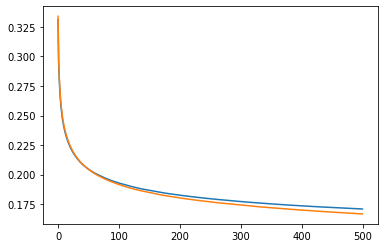

In [ ]:
plt.plot(mlp_l2.val_costs)
plt.plot(mlp_l2.costs)

In [ ]:
# Explore using grid search
# Here, we manually implement the grid search as our model also stores the validation loss
#Note that as the model training using numpy only is crawlingly slow, we limit our search space to
# separate small sets of l1 and l2 regularization
l1_list = [0.01, 0.1, 0.4, 0.8, 1]
lr = 0.02
nitr = 300 #Epochs for training model
tol = 5 #Tolerance epochs
epsilon = 1e-5 #Tolerance threshold for early stopping

slcted_l1 = []
finl1_val_cost = []
for ii in range(20):
    tmp_l1 = l1_list[np.random.randint]
    slcted_l1.append(tmp_l1)

    mlp_grid = MLP(activation_func = tanh, activation_deriv= tanh_derivative, n=x_train_vector.shape[0], 
          layer_size = [inp_dim, 256, 256, 10], btch_sz=256, train_set = train_set, 
          X=x_train_vector, Y=train_y)
    mlp_grid.fit_btch(lr=lr, nitr= nitr, alpha=0, beta=tmp_l1, tol=tol, epsilon=epsilon)
    finl1_val_cost.append(mlp_grid.val_costs[-1])



In [ ]:
mean_csts = []
for ii in enumerate(l1_list):
    tmp = np.mean(finl1_val_cost[slcted_l1==ii])
    mean_csts.append(tmp)
slctd_l1 = np.argmin(mean_csts)
print(f'selected L1:{l1_list[slctd_l1]}')

In [ ]:
#Perform grid search on l2 space
l2_list = [0.01, 0.1, 0.4, 0.8, 1]
lr = 0.01
nitr = 300 #Epochs for training model
tol = 5 #Tolerance epochs
epsilon = 1e-4 #Tolerance threshold for early stopping

slcted_l2 = []
finl2_val_cost = []
for ii in range(50):
    tmp_l2 = l2_list[np.random.randint]
    slcted_l2.append(tmp_l2)

    mlp_grid = MLP(activation_func = tanh, activation_deriv= tanh_derivative, n=x_train_vector.shape[0], 
          layer_size = [inp_dim, 256, 256, 10], btch_sz=256, train_set = train_set, 
          X=x_train_vector, Y=train_y)
    mlp_grid.fit_btch(lr=lr, nitr= nitr, alpha=tmp_l2, beta=0, tol=tol, epsilon=epsilon)
    finl2_val_cost.append(mlp_grid.val_costs[-1])

In [ ]:
mean_csts = []
for ii in enumerate(l2_list):
    tmp = np.mean(finl2_val_cost[slcted_l2==ii])
    mean_csts.append(tmp)
slctd_l2 = np.argmin(mean_csts)
print(f'selected L2:{l1_list[slctd_l2]}')

In [ ]:
mlp_lrelu_dic['train_time']

6379.2937388420105

## Train and observe the performance of MLP models with 3 256 layers and two 512 layers

In [ ]:
# Activation functions: relu, leaky_relu, tanh
# Derivative: tanh_derivative, relu_derivative, leaky_relu_derivative

mlp_3 = MLP(activation_func = relu, activation_deriv= relu_derivative, n=x_train_vector.shape[0], 
          layer_size = [inp_dim, 256, 256, 256, 10], btch_sz=256, train_set = train_set, 
          X=x_train_vector, Y=train_y)

In [ ]:
t1 = time.time()
mlp_3.fit_btch(lr=0.01, nitr= 500, alpha=0, beta=0, tol=5, epsilon=1e-5)
t2 = time.time()

Iteration: 0
Cost:  0.26137174618991926 Train Accuracy: 13.168888888888889
validation cost: 0.2612198405722894 Validation accuracy: 13.5
Iteration: 1
Iteration: 2
Cost:  0.2399050978540756 Train Accuracy: 16.295555555555556
validation cost: 0.23965815435987722 Validation accuracy: 16.56
Iteration: 3
Iteration: 4
Cost:  0.23066195947601786 Train Accuracy: 18.664444444444445
validation cost: 0.23041263316142926 Validation accuracy: 19.220000000000002
Iteration: 5
Iteration: 6
Cost:  0.22464899939183092 Train Accuracy: 20.333333333333332
validation cost: 0.22442366100769198 Validation accuracy: 20.76
Iteration: 7
Iteration: 8
Cost:  0.2202837610319611 Train Accuracy: 21.50888888888889
validation cost: 0.22010733191787324 Validation accuracy: 21.9
Iteration: 9
Iteration: 10
Cost:  0.21685971872001855 Train Accuracy: 22.482222222222223
validation cost: 0.21676938649207156 Validation accuracy: 23.06
Iteration: 11
Iteration: 12
Cost:  0.2141091312253045 Train Accuracy: 23.493333333333332
vali

In [ ]:
mlp_3_perf = {'test_perf': mlp_3.evaluate_acc(x_test_vector, test_y), 'train_time': t2-t1,
            'train_cost': mlp_3.costs, 'val_cost': mlp_3.val_costs}

In [ ]:
with open('mlp_3.pickle', 'wb') as h:
    pickle.dump(mlp_3_perf, h)

In [ ]:
# get the folder id where you want to save your file
file = drive.CreateFile()
file.SetContentFile('mlp_3.pickle')
file.Upload()

In [ ]:
# Activation functions: relu, leaky_relu, tanh
# Derivative: tanh_derivative, relu_derivative, leaky_relu_derivative

mlp_512 = MLP(activation_func = relu, activation_deriv= relu_derivative, n=x_train_vector.shape[0], 
          layer_size = [inp_dim, 512, 512, 10], btch_sz=256, train_set = train_set, 
          X=x_train_vector, Y=train_y)

In [ ]:
t1 = time.time()
mlp_512.fit_btch(lr=0.01, nitr= 500, alpha=0, beta=0, tol=5, epsilon=1e-5)
t2 = time.time()

Iteration: 0
Cost:  0.297380617657668 Train Accuracy: 12.70888888888889
validation cost: 0.29648465550192415 Validation accuracy: 13.28
Iteration: 1
Iteration: 2
Cost:  0.26285287075162567 Train Accuracy: 17.624444444444446
validation cost: 0.2622342015834318 Validation accuracy: 18.16
Iteration: 3
Iteration: 4
Cost:  0.24690327690177458 Train Accuracy: 20.44
validation cost: 0.24659277812776006 Validation accuracy: 20.64
Iteration: 5
Iteration: 6
Cost:  0.23708724671167164 Train Accuracy: 22.38
validation cost: 0.2370201899999708 Validation accuracy: 23.119999999999997
Iteration: 7
Iteration: 8
Cost:  0.2302006495427071 Train Accuracy: 23.795555555555556
validation cost: 0.2303721882903865 Validation accuracy: 24.44
Iteration: 9
Iteration: 10
Cost:  0.22503865099290132 Train Accuracy: 24.897777777777776
validation cost: 0.22540872012708402 Validation accuracy: 25.5
Iteration: 11
Iteration: 12
Cost:  0.22091608732451762 Train Accuracy: 25.986666666666668
validation cost: 0.221474570272

In [ ]:
mlp_512_perf = {'test_perf': mlp_512.evaluate_acc(x_test_vector, test_y), 'train_time': t2-t1,
            'train_cost': mlp_512.costs, 'val_cost': mlp_512.val_costs}

In [ ]:
with open('mlp_512.pickle', 'wb') as h:
    pickle.dump(mlp_512_perf, h)

In [ ]:
# get the folder id where you want to save your file
file = drive.CreateFile()
file.SetContentFile('mlp_512.pickle')
file.Upload()

### Use pytorch and GPU to create and train two MLP models:


*   One with 2 256 layers and no momentum to validate our custome model
*   another with 1024 512 layers and momentum





In [ ]:
model = torch.nn.Sequential(
    torch.nn.Linear(inp_dim, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 10),
    torch.nn.Softmax()
)

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
train_set_torch = TrainSet(x_train_vector, y_train)
train_dat = DataLoader(train_set_torch, batch_size=256, shuffle=True)


In [ ]:
dvc= torch.device('cuda')
model.to(dvc)

Sequential(
  (0): Linear(in_features=3072, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=10, bias=True)
  (5): Softmax(dim=None)
)

In [ ]:


loss_ls = []

start_time= time.time()
for epoch in range(500):  # loop over the dataset multiple times

    print(f'Epoch: {epoch}')

    for ind, data in enumerate(train_dat):
        # get the inputs; data is a list of [inputs, labels]
        x, y = data        
        x = x.to(dvc)
        y = y.to(dvc)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model.forward(x.to(torch.float32))
        loss_val = loss_fn(outputs, y.reshape(-1))
        loss_val.backward()
        optimizer.step()
        # print statistics

    # set iteration time
    
    
    

            
    # calculate accuracy
    with torch.no_grad():
        val_pred = model.forward(torch.tensor(x_val_vector).to(torch.float32).to(dvc))
        val_los = loss_fn(val_pred, torch.tensor(y_val.reshape(-1)).to(dvc))
        val_pred_clas = torch.argmax(val_pred, axis=1)
        val_pred_clas = val_pred_clas.detach().cpu().numpy()

        val_ac = 100 * np.mean(val_pred_clas.reshape(-1) == y_val.reshape(-1))
    loss_ls.append(val_los.item())
    
    print(f'Accuracy and loss of the network on validations set: {val_ac, val_los.item()}')
    


Epoch: 0


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Accuracy and loss of the network on validations set: (11.62, 2.301917314529419)
Epoch: 1
Accuracy and loss of the network on validations set: (13.44, 2.3014914989471436)
Epoch: 2
Accuracy and loss of the network on validations set: (14.92, 2.3010494709014893)
Epoch: 3
Accuracy and loss of the network on validations set: (13.62, 2.3005895614624023)
Epoch: 4
Accuracy and loss of the network on validations set: (11.62, 2.3001134395599365)
Epoch: 5
Accuracy and loss of the network on validations set: (10.5, 2.299605369567871)
Epoch: 6
Accuracy and loss of the network on validations set: (10.040000000000001, 2.299044132232666)
Epoch: 7
Accuracy and loss of the network on validations set: (10.0, 2.29842209815979)
Epoch: 8
Accuracy and loss of the network on validations set: (9.94, 2.29773211479187)
Epoch: 9
Accuracy and loss of the network on validations set: (9.94, 2.2969582080841064)
Epoch: 10
Accuracy and loss of the network on validations set: (10.02, 2.2960898876190186)
Epoch: 11
Accura

In [ ]:
with torch.no_grad():
    tst_pred = model.forward(torch.tensor(x_test_vector).to(torch.float32).to(dvc))
    tst_los = loss_fn(tst_pred, torch.tensor(y_test.reshape(-1)).to(dvc))
    tst_pred_clas = torch.argmax(tst_pred, axis=1)
    tst_pred_clas = tst_pred_clas.detach().cpu().numpy()

    tst_ac = 100 * np.mean(tst_pred_clas.reshape(-1) == y_test.reshape(-1))

    
    print(f'Accuracy and loss of the network on test set: {tst_ac, tst_los.item()}. Fairly close to our results ')

In [ ]:
# 1024 512
model = torch.nn.Sequential(
    torch.nn.Linear(inp_dim, 1024),
    torch.nn.ReLU(),
    torch.nn.Linear(1024, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 10),
    torch.nn.Softmax()
)

In [ ]:
# With momentum
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
train_set_torch = TrainSet(x_train_vector, y_train)
train_dat = DataLoader(train_set_torch, batch_size=256, shuffle=True)


In [ ]:
dvc= torch.device('cuda')
model.to(dvc)

Sequential(
  (0): Linear(in_features=3072, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=10, bias=True)
  (5): Softmax(dim=None)
)

In [ ]:
loss_ls = []

for epoch in range(200):  # loop over the dataset multiple times

    print(f'Epoch: {epoch}')

    for ind, data in enumerate(train_dat):
        # get the inputs; data is a list of [inputs, labels]
        x, y = data        
        x = x.to(dvc)
        y = y.to(dvc)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model.forward(x.to(torch.float32))
        loss_val = loss_fn(outputs, y.reshape(-1))
        loss_val.backward()
        optimizer.step()
        # print statistics

    # set iteration time
    
    
    

            
    # calculate accuracy
    with torch.no_grad():
        val_pred = model.forward(torch.tensor(x_val_vector).to(torch.float32).to(dvc))
        val_los = loss_fn(val_pred, torch.tensor(y_val.reshape(-1)).to(dvc))
        val_pred_clas = torch.argmax(val_pred, axis=1)
        val_pred_clas = val_pred_clas.detach().cpu().numpy()

        val_ac = 100 * np.mean(val_pred_clas.reshape(-1) == y_val.reshape(-1))
    loss_ls.append(val_los.item())
    
    print(f'Accuracy and loss of the network on validations set: {val_ac, val_los.item()}')
    


Epoch: 0
Accuracy and loss of the network on validations set: (10.38, 2.2967255115509033)
Epoch: 1
Accuracy and loss of the network on validations set: (11.44, 2.2829294204711914)
Epoch: 2
Accuracy and loss of the network on validations set: (18.7, 2.258939266204834)
Epoch: 3
Accuracy and loss of the network on validations set: (22.939999999999998, 2.2289934158325195)
Epoch: 4
Accuracy and loss of the network on validations set: (24.44, 2.204228401184082)
Epoch: 5
Accuracy and loss of the network on validations set: (26.919999999999998, 2.1892287731170654)
Epoch: 6
Accuracy and loss of the network on validations set: (27.560000000000002, 2.1796281337738037)
Epoch: 7
Accuracy and loss of the network on validations set: (28.68, 2.1721079349517822)
Epoch: 8
Accuracy and loss of the network on validations set: (29.12, 2.1671595573425293)
Epoch: 9
Accuracy and loss of the network on validations set: (29.4, 2.160322427749634)
Epoch: 10
Accuracy and loss of the network on validations set: (29

In [ ]:
with torch.no_grad():
    tst_pred = model.forward(torch.tensor(x_test_vector).to(torch.float32).to(dvc))
    tst_los = loss_fn(tst_pred, torch.tensor(y_test.reshape(-1)).to(dvc))
    tst_pred_clas = torch.argmax(tst_pred, axis=1)
    tst_pred_clas = tst_pred_clas.detach().cpu().numpy()

    tst_ac = 100 * np.mean(tst_pred_clas.reshape(-1) == y_test.reshape(-1))

    
    print(f'Accuracy and loss of the network on test set: {tst_ac, tst_los.item()}. Fairly close to our results ')

Accuracy and loss of the network on test set: (51.15, 1.9462952613830566). Fairly close to our results 


## Plotting using the saved performances. No need to run on a new platform

In [ ]:
from google.colab import drive as drv

In [ ]:
# Mount drive
drv.mount('/content/drive')

Mounted at /content/drive


In [ ]:

dir = '/content/drive/MyDrive/'
with open(dir+'mlp_1.pickle', 'rb') as h:
    mlp_1_dic = pickle.load(h)

with open(dir+'mlp_2.pickle', 'rb') as h:
    mlp_2_dic = pickle.load(h)
with open(dir+'mlp_ful.pickle', 'rb') as h:
    mlp_ful_dic = pickle.load(h)
with open(dir+'mlp_l1.pickle', 'rb') as h:
    mlp_l1_dic = pickle.load(h)
with open(dir+'mlp_l2.pickle', 'rb') as h:
    mlp_l2_dic = pickle.load(h)
with open(dir+'mlp_lrelu.pickle', 'rb') as h:
    mlp_lrelu_dic = pickle.load(h)
with open(dir+'mlp_noh.pickle', 'rb') as h:
    mlp_noh_dic = pickle.load(h)
with open(dir+'mlp_tanh.pickle', 'rb') as h:
    mlp_tanh_dic = pickle.load(h)
with open(dir+'mlp_3.pickle', 'rb') as h:
    mlp_3_dic = pickle.load(h)
with open(dir+'mlp_512.pickle', 'rb') as h:
    mlp_512_dic = pickle.load(h)

Text(0, 0.5, 'Loss')

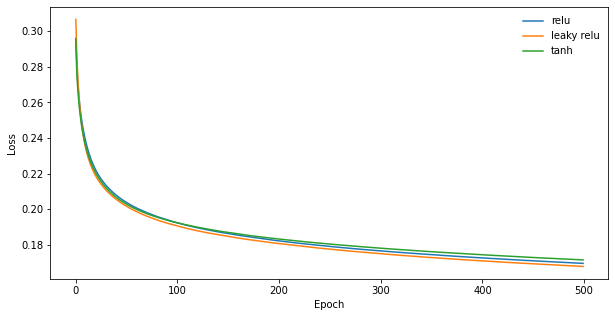

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(mlp_ful_dic['train_cost'], label='relu')
plt.plot(mlp_lrelu_dic['train_cost'], label='leaky relu')
plt.plot(mlp_tanh_dic['train_cost'], label='tanh')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.savefig('fig1.png', format='png', dpi=150)

Text(0, 0.5, 'Loss')

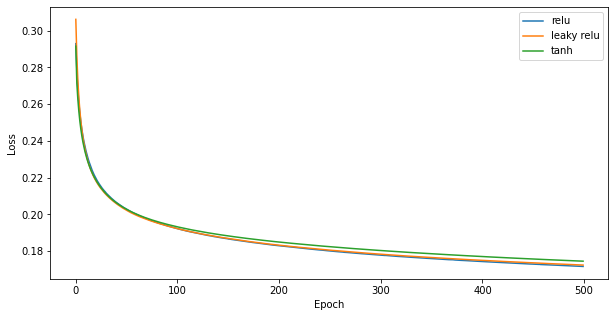

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(mlp_ful_dic['val_cost'], label='relu')
plt.plot(mlp_lrelu_dic['val_cost'], label='leaky relu')
plt.plot(mlp_tanh_dic['val_cost'], label='tanh')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.savefig('fig1.png', format='png', dpi=150)

For test performance, the result is reported as (accuracy, loss)

In [ ]:
print(f"Final test performance of model with relu activation: {mlp_ful_dic['test_perf']}")
print(f"Final test performance of model with leaky relu activation: {mlp_lrelu_dic['test_perf']}")
print(f"Final test performance of model with relu activation: {mlp_tanh_dic['test_perf']}")

Final performance of model with relu activation: (39.160000000000004, 0.17175061848872528)
Final performance of model with leaky relu activation: (39.82, 0.17175530266298739)
Final performance of model with relu activation: (39.83, 0.1724528572309131)


In [ ]:
print(f"Training time of model with relu activation: {mlp_2_dic['train_time']}s")
print(f"Training time of model with leaky relu activation: {mlp_lrelu_dic['train_time']}s")
print(f"Training time of model with relu activation: {mlp_tanh_dic['train_time']}s")

Training time of model with relu activation: 7398.999198436737
Training time of model with leaky relu activation: 6379.2937388420105
Training time of model with relu activation: 11145.086985826492


Text(0.5, 1.0, 'Training loss')

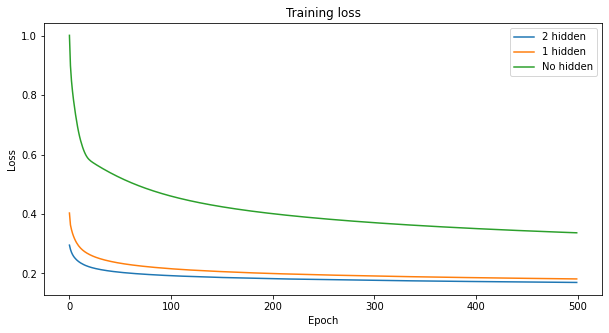

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(mlp_ful_dic['train_cost'], label='2 hidden')
plt.plot(mlp_1_dic['train_cost'], label='1 hidden')
plt.plot(mlp_noh_dic['train_cost'], label='No hidden')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
#plt.savefig('fig1.png', format='png', dpi=150)

Text(0.5, 1.0, 'Validation loss')

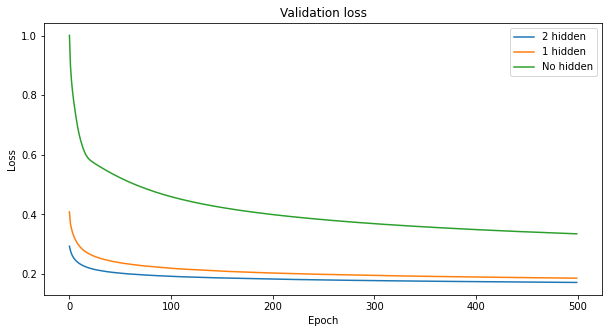

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(mlp_ful_dic['val_cost'], label='2 hidden')
plt.plot(mlp_1_dic['val_cost'], label='1 hidden')
plt.plot(mlp_noh_dic['val_cost'], label='No hidden')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation loss')
#plt.savefig('fig1.png', format='png', dpi=150)

In [ ]:
print(f"Final test performance of model with 2 hidden layers: {mlp_ful_dic['test_perf']}")
print(f"Final test performance of model with 1 hidden layer: {mlp_1_dic['test_perf']}")
print(f"Final test performance of model with no hidden layer: {mlp_noh_dic['test_perf']}")

Final test performance of model with 2 hidden layers: (39.160000000000004, 0.17175061848872528)
Final test performance of model with 1 hidden layer: (36.480000000000004, 0.1851969758531202)
Final test performance of model with no hidden layer: (20.119999999999997, 0.33889570300388094)


In [ ]:
print(f"Training time of model with 2 hidden layers: {mlp_2_dic['train_time']}s")
print(f"Training time of model with 1 hidden layer: {mlp_1_dic['train_time']}s")
print(f"Training time of model with no hidden layer: {mlp_noh_dic['train_time']}s")

Text(0.5, 1.0, 'Training loss')

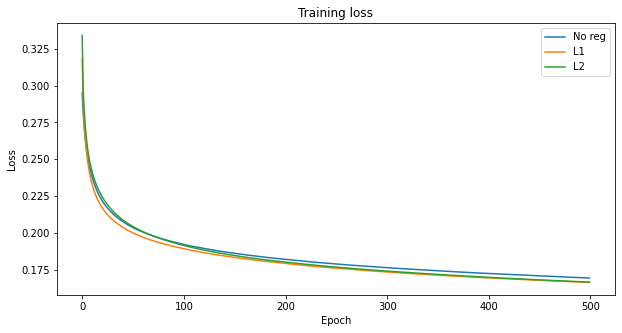

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(mlp_ful_dic['train_cost'], label='No reg')
plt.plot(mlp_l1_dic['train_cost'], label='L1')
plt.plot(mlp_l2_dic['train_cost'], label='L2')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
#plt.savefig('fig1.png', format='png', dpi=150)

Text(0.5, 1.0, 'Training loss')

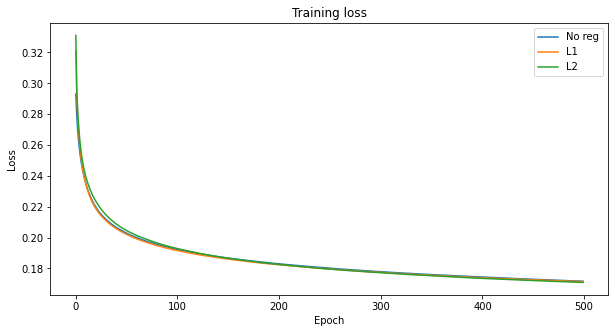

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(mlp_ful_dic['val_cost'], label='No reg')
plt.plot(mlp_l1_dic['val_cost'], label='L1')
plt.plot(mlp_l2_dic['val_cost'], label='L2')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
#plt.savefig('fig1.png', format='png', dpi=150)

In [ ]:
print(f"Final test performance of model with no regularization: {mlp_ful_dic['test_perf']}s")
print(f"Final test performance of model with L1 regularization: {mlp_l1_dic['test_perf']}s")
print(f"Final test performance of model with L2 regularization: {mlp_l2_dic['test_perf']}s")

Final test performance of model with no regularization: (39.160000000000004, 0.17175061848872528)
Final test performance of model with L1 regularization: (40.22, 0.16949206481186058)
Final test performance of model with L2 regularization: (40.47, 0.1694321672497076)


In [ ]:
print(f"Training time of model with no regulariation: {mlp_2_dic['train_time']}s")
print(f"Training time of model with L1 regularization: {mlp_l1_dic['train_time']}s")
print(f"Training time of model with L2 regularization: {mlp_l2_dic['train_time']}s")

Training time of model with no regulariation: 7398.999198436737
Training time of model with L1 regularization: 6880.1857097148895
Training time of model with L2 regularization: 7218.637221813202


Text(0.5, 1.0, 'Training loss')

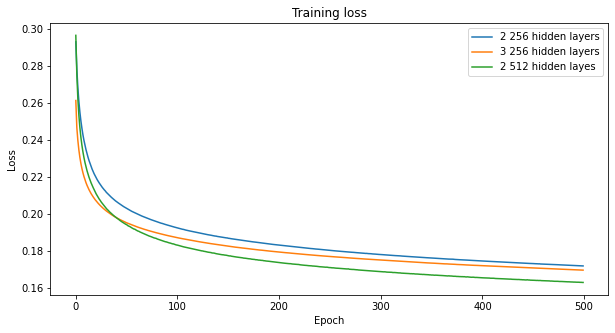

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(mlp_ful_dic['val_cost'], label='2 256 hidden layers')
plt.plot(mlp_3_dic['val_cost'], label='3 256 hidden layers')
plt.plot(mlp_512_dic['val_cost'], label='2 512 hidden layes')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
#plt.savefig('fig1.png', format='png', dpi=150)

In [ ]:
print(f"Test performance of model with 2 256 hidden layers: {mlp_ful_dic['test_perf']}")
print(f"Test performance of model with 3 256 hidden layers: {mlp_3_dic['test_perf']}")
print(f"Test performance of model with 2 512 hidden layers: {mlp_512_dic['test_perf']}")

Test performance of model with 2 256 hidden layers: (39.160000000000004, 0.17175061848872528)
Test performance of model with 3 256 hidden layers: (40.37, 0.16833193947218475)
Test performance of model with 2 512 hidden layers: (42.67, 0.16204763471677303)


In [ ]:
print(f"Training time of model with 2 256 hidden layers: {mlp_2_dic['train_time']}s")
print(f"Training time of model with 3 256 hidden layers: {mlp_3_dic['train_time']}s")
print(f"Training time of model with 2 512 hidden layers: {mlp_512_dic['train_time']}s")

Training time of model with 2 256 hidden layers: 7398.999198436737 s
Training time of model with 3 256 hidden layers: 8206.493489027023 s
Training time of model with 2 512 hidden layers: 14890.447857379913 s


## PyTorch: Convolutional Neural Network

Load the data

In [12]:
# Import the the CIFAR-10 dataset normalize the data
test_train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.225, 0.225, 0.225])
])

# Now load the appropriate training and test datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=test_train_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_train_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


MyCNN class with convolutional neural network architecture

In [13]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()

        # Conv layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=(3,3), stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3,3), stride=1, padding=1)
        # Fully connected layers
        self.fc1 = nn.Linear(32*8*8, 256)
        self.fc2 = nn.Linear(256, 256)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.50)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.pool(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        return x

Train the model

In [ ]:
# Initialize CNN
cnn = MyCNN().to(dvc)

# Define the loss function, optimizer, and loss list for later plotting
lossfunct = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.005, momentum=0.9)
loss_list = []

# Train the model on 40 epochs
for epoch in range(40):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs and labels
        inputs, labels = data
        inputs = inputs.to(dvc)
        labels = labels.to(dvc)

        # Initialize the parameter gradients to 0
        optimizer.zero_grad()

        # Forward, backward, and optimize
        outputs = cnn(inputs)
        loss = lossfunct(outputs, labels)
        loss.backward()
        optimizer.step()

        # Gather running loss
        running_loss += loss.item()
        max_i=i

    current_loss = running_loss / max_i
    loss_list.append(current_loss)
    running_loss = 0.0 

    # Calculate training accuracy after each epoch
    with torch.no_grad():
        correct = 0
        total = 0
        for data in train_loader:
            # Get the inputs and labels again
            inputs, labels = data
            inputs = inputs.to(dvc)
            labels = labels.to(dvc)
            outputs = cnn(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    current_accuracy = 100 * correct / total

    print('[' + str(epoch + 1) + '] loss: ' + str(round(current_loss, 3)) + ', accuracy: ' + str(current_accuracy))

print('Done training')

[1] loss: 1.798, accuracy: 47.014
[2] loss: 1.431, accuracy: 48.866
[3] loss: 1.324, accuracy: 53.774
[4] loss: 1.257, accuracy: 57.55
[5] loss: 1.2, accuracy: 57.664
[6] loss: 1.153, accuracy: 60.294
[7] loss: 1.123, accuracy: 59.716
[8] loss: 1.102, accuracy: 61.988


Plot the loss of the train set over each epoch

Text(0, 0.5, 'Running Loss')

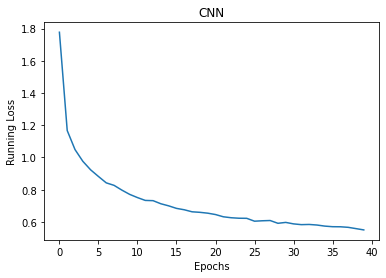

In [10]:
plt.plot(loss_list)
plt.title("CNN")
plt.xlabel("Epochs")
plt.ylabel("Running Loss")

Gather the test accuracy

In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(dvc)
        labels = labels.to(dvc)
        outputs = cnn(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Test accuracy: ' + str(100 * correct / total))

Test accuracy: 68.45


## Resnet18: *Pre-Trained model*




In [ ]:
resnet = models.resnet18(pretrained=True)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
#Freezing convolutional layers
for param in resnet.parameters():
    param.requires_grad = False

# Remove fully connected layers
num_features = resnet.fc.in_features
resnet.fc = nn.Identity()
# Define new fully connected layers
new_fc = nn.Sequential(
    nn.Linear(num_features,512),
    nn.ReLU(),
    nn.Linear(512, 10)
    #nn.ReLU(),
    #nn.Linear(128, 10)
)
resnet.fc = new_fc

In [ ]:
dvc= torch.device('cuda')
resnet.to(dvc)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.005, momentum=0.9)

loss = torch.nn.CrossEntropyLoss()



In [ ]:
loss_list_gpu=[]
acc_list_gpu=[]
start_time_pytorch = time.time()
for epoch in range(50):  # loop over the dataset multiple times
    correct = 0
    total = 0
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs= inputs.to(dvc)
        labels= labels.to(dvc)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet(inputs)
        loss_val= loss(outputs, labels)
        loss_val.backward()
        optimizer.step()
        # print statistics
        running_loss += loss_val.item()
        max_i=i
    # set iteration time
    iter_time = time.time()-start_time_pytorch
    print(f'[{epoch + 1}] loss: {running_loss/max_i:.3f} time: {iter_time:.2f} seconds')
    loss_list_gpu.append(running_loss/max_i)

            
    # calculate accuracy
    with torch.no_grad():
        for data in trainloader:
            inputs, labels = data
            inputs= inputs.to(dvc)
            labels= labels.to(dvc)
            outputs = resnet(inputs)

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    acc_list_gpu.append(accuracy)
    print(f'Accuracy of the network on the training images: {accuracy:.2f}%')


# set iteration time time
end_time = time.time()
# calculate total running time
total_time = end_time - start_time_pytorch

print(f'Finished Training. Total running time: {total_time:.2f} seconds')

[1] loss: 1.848 time: 18.49 seconds
Accuracy of the network on the training images: 44.32%
[2] loss: 1.598 time: 44.16 seconds
Accuracy of the network on the training images: 46.86%
[3] loss: 1.539 time: 69.82 seconds
Accuracy of the network on the training images: 47.67%
[4] loss: 1.504 time: 97.56 seconds
Accuracy of the network on the training images: 49.23%
[5] loss: 1.477 time: 123.84 seconds
Accuracy of the network on the training images: 49.63%
[6] loss: 1.451 time: 150.13 seconds
Accuracy of the network on the training images: 50.72%
[7] loss: 1.426 time: 176.27 seconds
Accuracy of the network on the training images: 51.75%
[8] loss: 1.399 time: 203.03 seconds
Accuracy of the network on the training images: 52.67%
[9] loss: 1.379 time: 228.99 seconds
Accuracy of the network on the training images: 53.32%
[10] loss: 1.354 time: 254.66 seconds
Accuracy of the network on the training images: 54.08%
[11] loss: 1.336 time: 280.08 seconds
Accuracy of the network on the training image

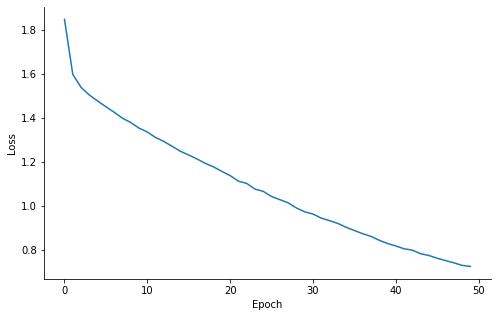

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(loss_list_gpu)
plt.ylabel('Loss')
plt.xlabel('Epoch')
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)
plt.savefig('resnet.png', dpi=150)

In [ ]:
# calculate accuracy
correct_tst = 0
total_tst = 0
resnet.eval()
for data in testloader:
    inputs, labels = data
    inputs= inputs.to(dvc)
    labels= labels.to(dvc)
    outputs = resnet(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total_tst += labels.size(0)
    correct_tst += (predicted == labels).sum().item()

accuracy_tst = 100 * correct_tst / total_tst
print(f'Resnet test accuracy: {accuracy_tst}')

Resnet test accuracy: 48.35


In [ ]:
# calculate accuracy
correct_tst = 0
total_tst = 0
resnet.eval()
for data in trainloader:
    inputs, labels = data
    inputs= inputs.to(dvc)
    labels= labels.to(dvc)
    outputs = resnet(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total_tst += labels.size(0)
    correct_tst += (predicted == labels).sum().item()

accuracy_tst = 100 * correct_tst / total_tst
print(f'Resnet train accuracy: {accuracy_tst}')

Resnet train accuracy: 83.034
